## Assignment 3
# ANN

In [47]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [48]:
# CONSTANTS
NUM_HIDDN = [16,32]
ALPHA = 0.001
NUM_EPOCH = 1000
BATCH_SIZE = 100


plt.style.use("ggplot")

In [49]:
def label_count(train_data, test_data):
    # Calculate the frequency of each label in the training and testing datasets,
    train_counts = train_data["label"].value_counts().sort_index()
    test_counts = test_data['label'].value_counts().sort_index()

    label_counts = pd.concat([train_counts,test_counts],axis=1)
    label_counts.columns=["Training Label Count","Testing Label Count"]
    return label_counts

In [50]:
def vectorize_dataframe(dataframe:pd.DataFrame,target="label"):
    X,y= None,None
    if target not in dataframe.columns:
        raise ValueError(f"{target} Variable Not In Given Dataframe")
    y = dataframe[target].to_numpy().flatten()
    X = dataframe.drop(target,axis=1).to_numpy()
    return X,y

In [51]:
def train_and_plot(learning_rate=ALPHA,batch_size=BATCH_SIZE,layers = NUM_HIDDN,X_train=None,y_train=None,ax=plt):
    ann = MLPClassifier(
        hidden_layer_sizes=layers,
        learning_rate="constant",
        learning_rate_init=learning_rate,
        batch_size=batch_size,
        solver="sgd",
        verbose=True,
        early_stopping=True,
        validation_fraction=0.2,
        max_iter=1000,
        shuffle=True,
    )

    ann.fit(X_train, y_train)

    epochs = range(1,len(ann.loss_curve_)+1)
    ax.plot(epochs, ann.loss_curve_, label="Training Error", color="blue")
    ax.plot(
        epochs,
        1 - np.array(ann.validation_scores_),
        label="Validation Error",
        color="red",
    )

    # Formatting the plot
    ax.set_title(
        f"LR: {learning_rate}       Batch: {batch_size}     Layers: {layers}", fontsize=11, pad=5, color="black"
    )
    ax.label_outer()
    ax.set_xticks(epochs)

    # Display convergence epoch
    ax.text(
        0.90,
        0.70,
        f"Converged in {ann.n_iter_} epochs",
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
        color="blue",
        fontsize=10,
    )
    ax.grid("off")

    ax.legend(loc="upper right", fontsize=9,labelcolor= "black",facecolor="white",frameon=True)
    return ann

In [52]:
def get_errors(modle,X_train,y_train,X_val,y_val,X_test,y_test):
    train_error = 1 - accuracy_score(y_train, modle.predict(X_train))
    validation_error = 1 - accuracy_score(y_val, modle.predict(X_val))
    test_error = 1 - accuracy_score(y_test, modle.predict(X_test))
    return train_error,validation_error,test_error

In [53]:
def plot_error_results(results,parameter="MISSING"):
    df = pd.DataFrame(results).T
    df.columns = ["Training error", "Validation Error", "Test Error"]
    ax = df.plot(kind="bar", figsize=(15, 5), colormap="viridis", edgecolor="black")

    ax.set_title(f"Errors With Varing {parameter}", fontsize=11, pad=5, color="black")
    ax.set_ylabel("Error Rate", fontsize=12)
    ax.set_xlabel(f"Models With Varing {parameter}", fontsize=12)
    ax.legend(
        title="Error Type",
        fontsize=10,
        facecolor="white",
        labelcolor="black",
        frameon=True
    )
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.savefig(f"errors_in_varing_{parameter}.png", transparent=True)
    print(df)

In [54]:
# CHECK FOR DATAFILES
DATA_DIR = './archive'
assert os.path.exists(DATA_DIR),"Data Directory Not Found,Update DIR_PATH Variable"

In [55]:
# DATA LOADING
test_data = pd.read_csv(os.path.join(DATA_DIR,"mnist_test.csv"))
train_data = pd.read_csv(os.path.join(DATA_DIR,"mnist_train.csv"))

## QUICK EDA

In [56]:
print(f"TEST DATA SHAPE :{test_data.shape}")
print(f"TRAIN DATA SHAPE : {train_data.shape}")

TEST DATA SHAPE :(10000, 785)
TRAIN DATA SHAPE : (60000, 785)


In [57]:
train_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Label Count on Original Data
labels_original = label_count(train_data,test_data)
labels_original

,Training Label Count,Testing Label Count
label,,
0,5923,980
1,6742,1135
2,5958,1032
3,6131,1010
4,5842,982
5,5421,892
6,5918,958
7,6265,1028
8,5851,974


## Update Datasets
For given experiments, you just need to work with samples from class 0 to 4 (5 classes)


In [59]:
BREAKPOINT = 5
train_data = train_data[train_data["label"]<BREAKPOINT]
test_data = test_data[test_data["label"]<BREAKPOINT]

In [60]:
print(f"TEST DATA SHAPE :{test_data.shape}")
print(f"TRAIN DATA SHAPE : {train_data.shape}")

TEST DATA SHAPE :(5139, 785)
TRAIN DATA SHAPE : (30596, 785)


In [61]:
# Label Counts and checking number of classes in updated datasets
updated_labels = label_count(train_data,test_data)
updated_labels

,Training Label Count,Testing Label Count
label,,
0,5923,980
1,6742,1135
2,5958,1032
3,6131,1010
4,5842,982


In [62]:
CLASSESS =updated_labels.index.to_list()
CLASSESS

[0, 1, 2, 3, 4]

### Convert clean dataframes to vectors

In [63]:
X_train, y_train = vectorize_dataframe(train_data)
X_test, y_test = vectorize_dataframe(test_data)

In [64]:
# Standardize Datasets
scaler = StandardScaler()
X_train = X_train/255 #scaler.fit_transform(X_train)
X_test = X_test/255 #scaler.transform(X_test)


In [65]:
X_train, X_val, y_train,y_val = train_test_split(X_train,y_train,test_size=.20,random_state=65)

In [66]:
ann = MLPClassifier(hidden_layer_sizes=NUM_HIDDN,learning_rate="constant",learning_rate_init=ALPHA,max_iter=NUM_EPOCH,batch_size=BATCH_SIZE,solver="sgd",early_stopping=True,validation_fraction=.2)

In [67]:
ann.fit(X_train,y_train)

MLPClassifier(batch_size=100, early_stopping=True, hidden_layer_sizes=[16, 32],
              max_iter=1000, solver='sgd', validation_fraction=0.2)

## Report training, validation, and testing errors

In [68]:
results_modle_1 = {
    "Model1": get_errors(ann, X_train, y_train, X_val, y_val, X_test, y_test)
}

        Training error  Validation Error  Test Error
Model1        0.015607          0.019771    0.017513


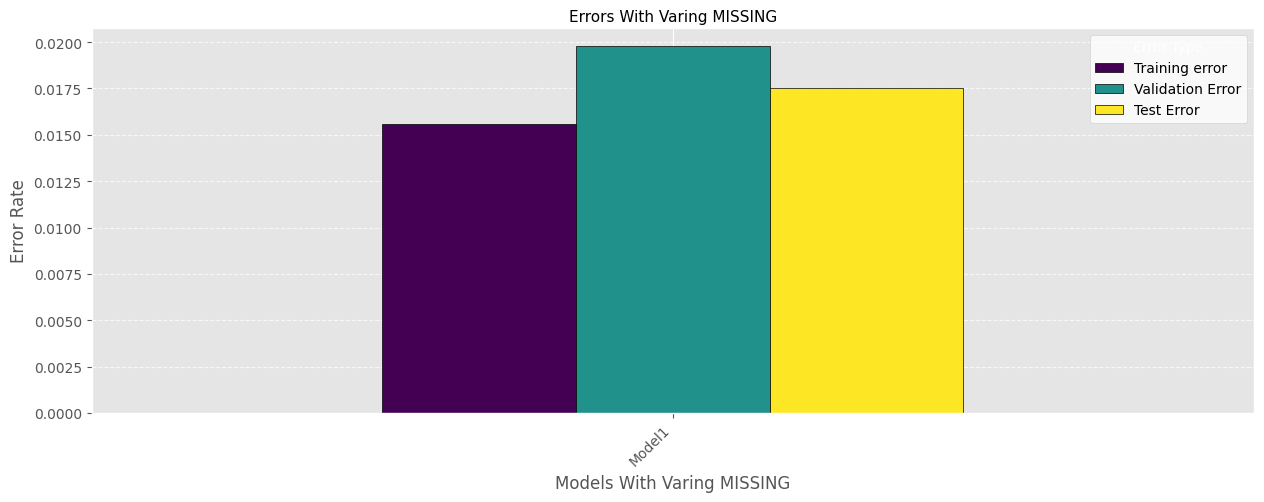

In [69]:
plot_error_results(results_modle_1)

In [70]:
train_errors  = ann.loss_curve_
val_errors = 1-np.array(ann.validation_scores_)

### Plot of error curves (training and validation).

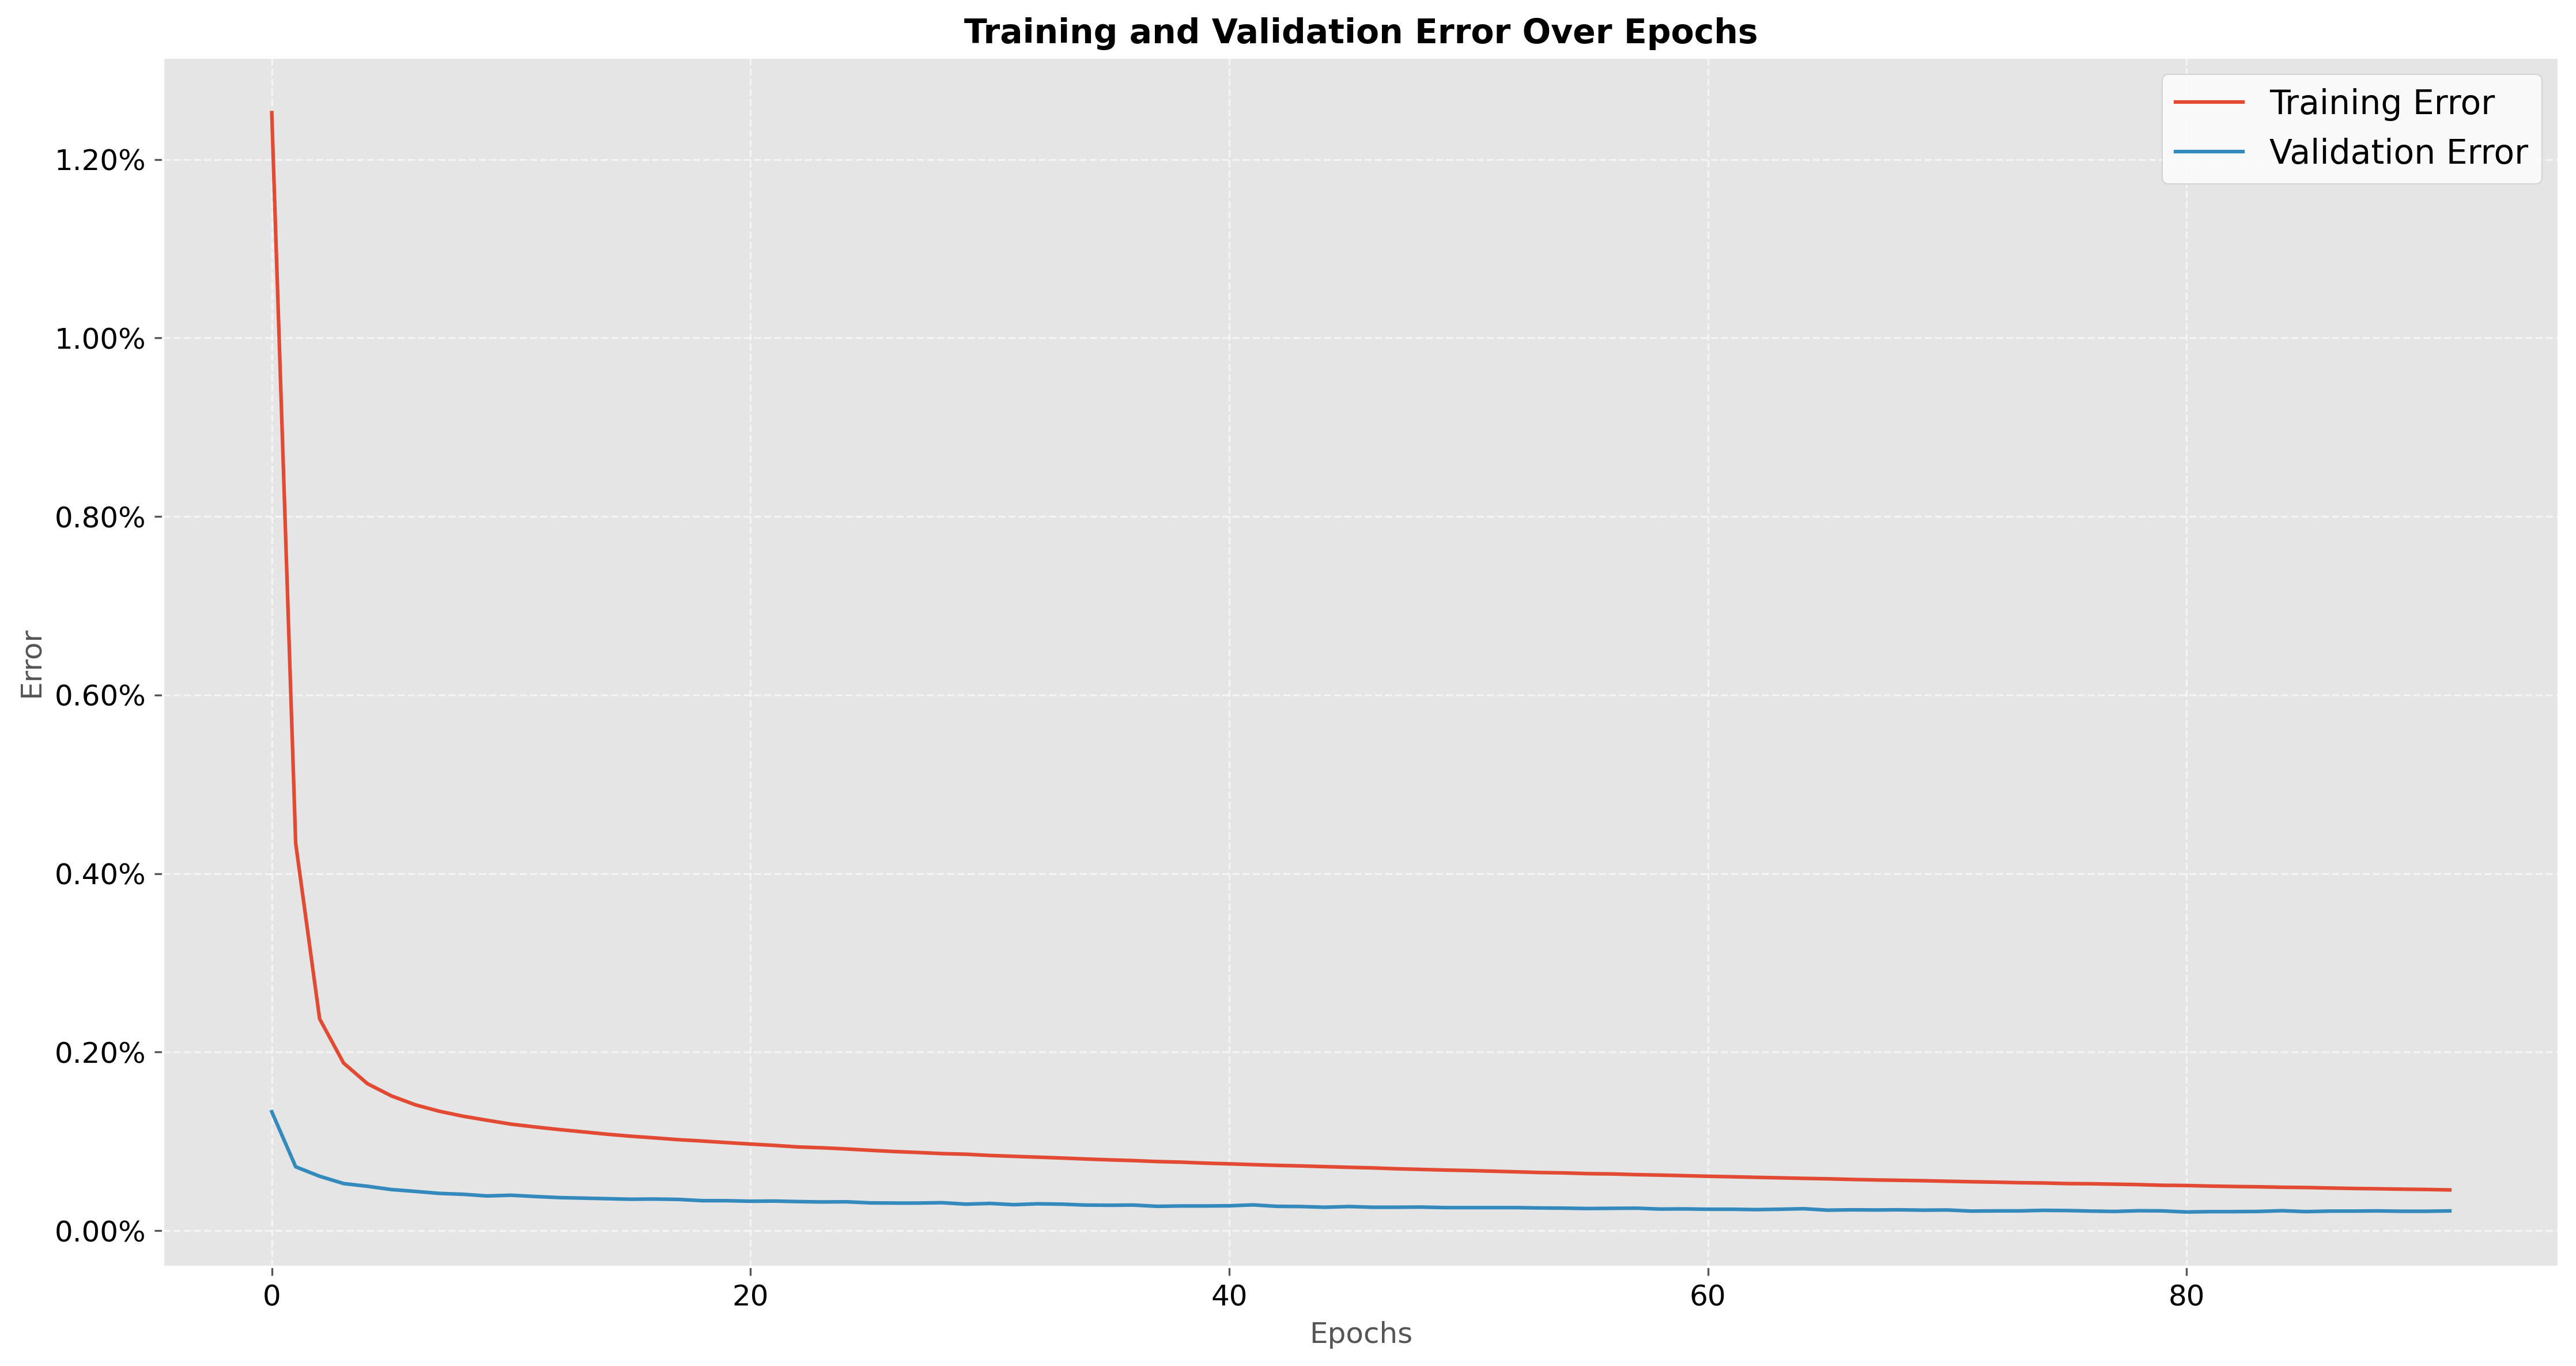

In [71]:
plt.figure(figsize=(15,8),dpi=300)
plt.plot(range(len(train_errors)), train_errors, label="Training Error")
plt.plot(range(len(val_errors)),val_errors,label="Validation Error")

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Error", fontsize=12)

plt.title("Training and Validation Error Over Epochs", fontsize=14, fontweight="bold",color="black")
plt.legend(
    fontsize=14, loc="upper right", frameon=True, facecolor="white", labelcolor="black"
)


plt.grid(True, linestyle="--", alpha=0.6)

plt.xticks(fontsize=12,color='black')
plt.yticks(fontsize=12,color='black')

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_:f"{x:.2f}%"))
plt.tight_layout()
plt.savefig(
    "Training and Validation Error Over Epochs.png", transparent=True, dpi="figure"
)
plt.show()

# Different Testing Parameters

In [72]:
lrs  = [0.0001, 0.001, 0.01, 0.1, 1.0]
batches = [10, 50, 100, 500, 1000]
hidden_layers = [(2, 16), (16, 32), (64, 100)]

## Try different values of the learning rate.

Iteration 1, loss = 1.62958023
Validation score: 0.214665
Iteration 2, loss = 1.51425130
Validation score: 0.346405
Iteration 3, loss = 1.40362783
Validation score: 0.575572
Iteration 4, loss = 1.29524236
Validation score: 0.661765
Iteration 5, loss = 1.18730707
Validation score: 0.695670
Iteration 6, loss = 1.08037941
Validation score: 0.717729
Iteration 7, loss = 0.97413918
Validation score: 0.742647
Iteration 8, loss = 0.86715746
Validation score: 0.799020
Iteration 9, loss = 0.75907823
Validation score: 0.859477
Iteration 10, loss = 0.65527872
Validation score: 0.892361
Iteration 11, loss = 0.56366119
Validation score: 0.907884
Iteration 12, loss = 0.48899603
Validation score: 0.916871
Iteration 13, loss = 0.43086696
Validation score: 0.920752
Iteration 14, loss = 0.38607967
Validation score: 0.924020
Iteration 15, loss = 0.35133514
Validation score: 0.928309
Iteration 16, loss = 0.32391040
Validation score: 0.931781
Iteration 17, loss = 0.30193054
Validation score: 0.932598
Iterat

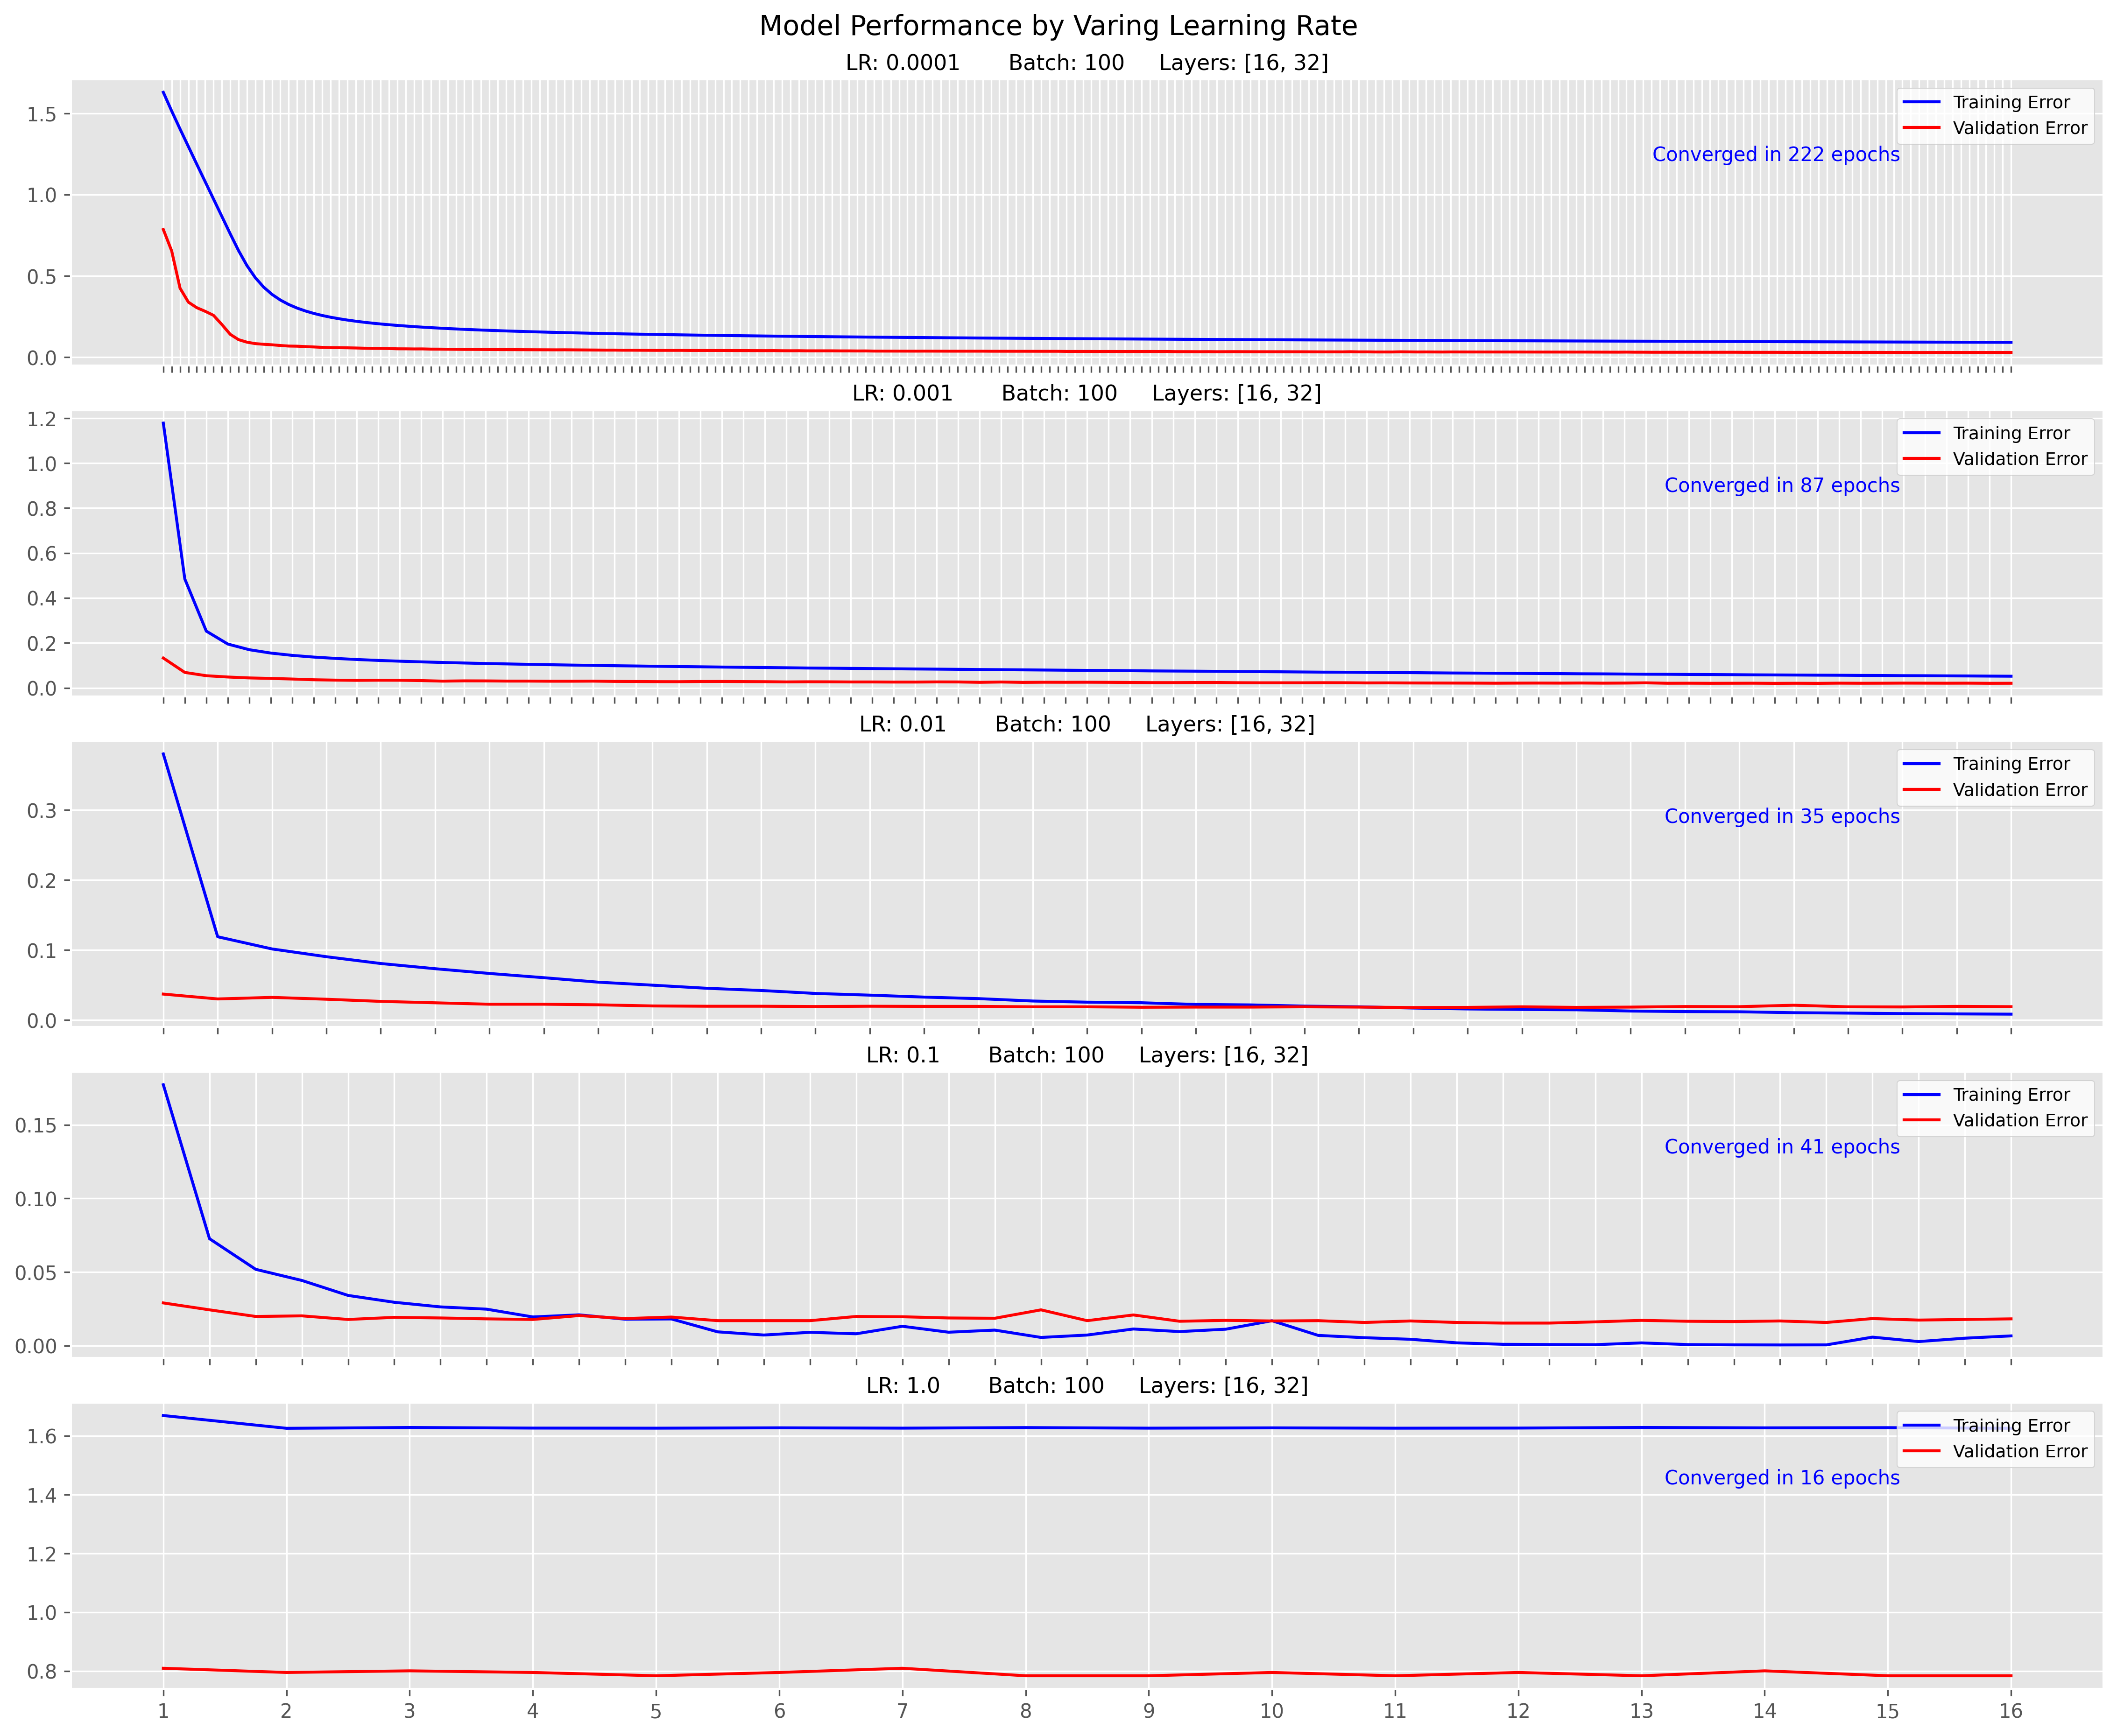

        Training error  Validation Error  Test Error
0.0001        0.027782          0.029412    0.022767
0.0010        0.017487          0.021078    0.017513
0.0100        0.006333          0.018137    0.013816
0.1000        0.003146          0.013235    0.009535
1.0000        0.780111          0.777778    0.779140


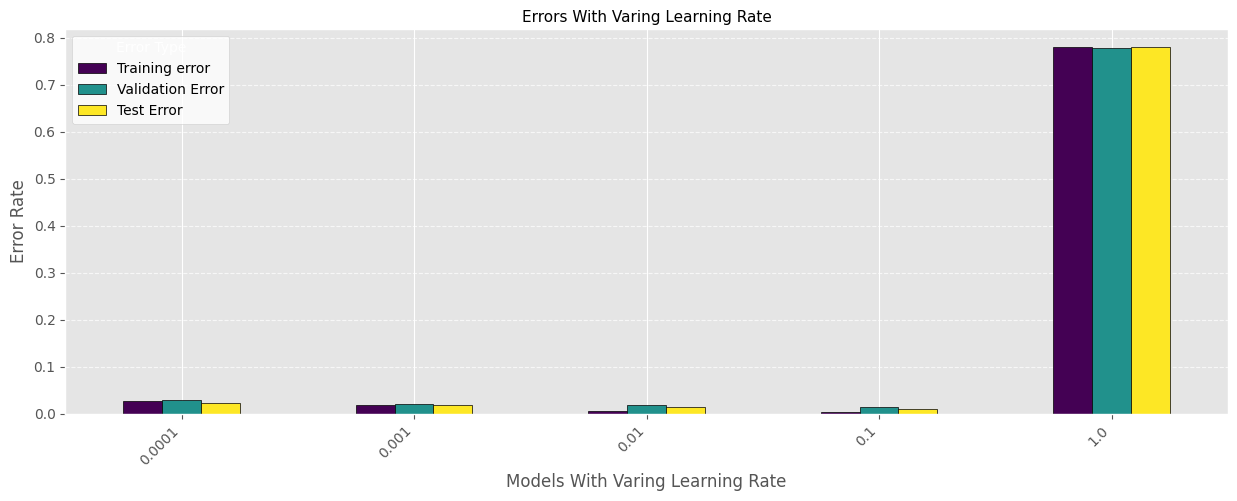

In [81]:
# Try 5 different settings from 0.0001 to 1.0. What happens to the convergence properties of the NN
fig, axes = plt.subplots(
    nrows=len(lrs), 
    ncols=1, 
    figsize=(15, 12), 
    dpi=300, 
    constrained_layout=True
)
fig.suptitle("Model Performance by Varing Learning Rate", y=1.02, fontsize=14,color="black")
results = {}
for i,lr in enumerate(lrs):
    model = train_and_plot(lr, BATCH_SIZE,NUM_HIDDN, X_train, y_train, axes[i])
    results.update({lr:get_errors(model,X_train,y_train,X_val,y_val,X_test,y_test)})
    del model
plt.savefig("varying_learning_rate.png", transparent=True)
plt.show()
plot_error_results(results,"Learning Rate")

Iteration 1, loss = 0.32186469
Validation score: 0.963031
Iteration 2, loss = 0.11726519
Validation score: 0.963644
Iteration 3, loss = 0.10192699
Validation score: 0.966503
Iteration 4, loss = 0.09309009
Validation score: 0.970997
Iteration 5, loss = 0.08523081
Validation score: 0.973039
Iteration 6, loss = 0.07998304
Validation score: 0.970588
Iteration 7, loss = 0.07438269
Validation score: 0.975082
Iteration 8, loss = 0.06973709
Validation score: 0.976103
Iteration 9, loss = 0.06504454
Validation score: 0.976511
Iteration 10, loss = 0.06118759
Validation score: 0.975286
Iteration 11, loss = 0.05820077
Validation score: 0.977328
Iteration 12, loss = 0.05529999
Validation score: 0.978350
Iteration 13, loss = 0.05210784
Validation score: 0.980188
Iteration 14, loss = 0.04875057
Validation score: 0.979371
Iteration 15, loss = 0.04614452
Validation score: 0.980801
Iteration 16, loss = 0.04395038
Validation score: 0.979779
Iteration 17, loss = 0.04167332
Validation score: 0.980596
Iterat

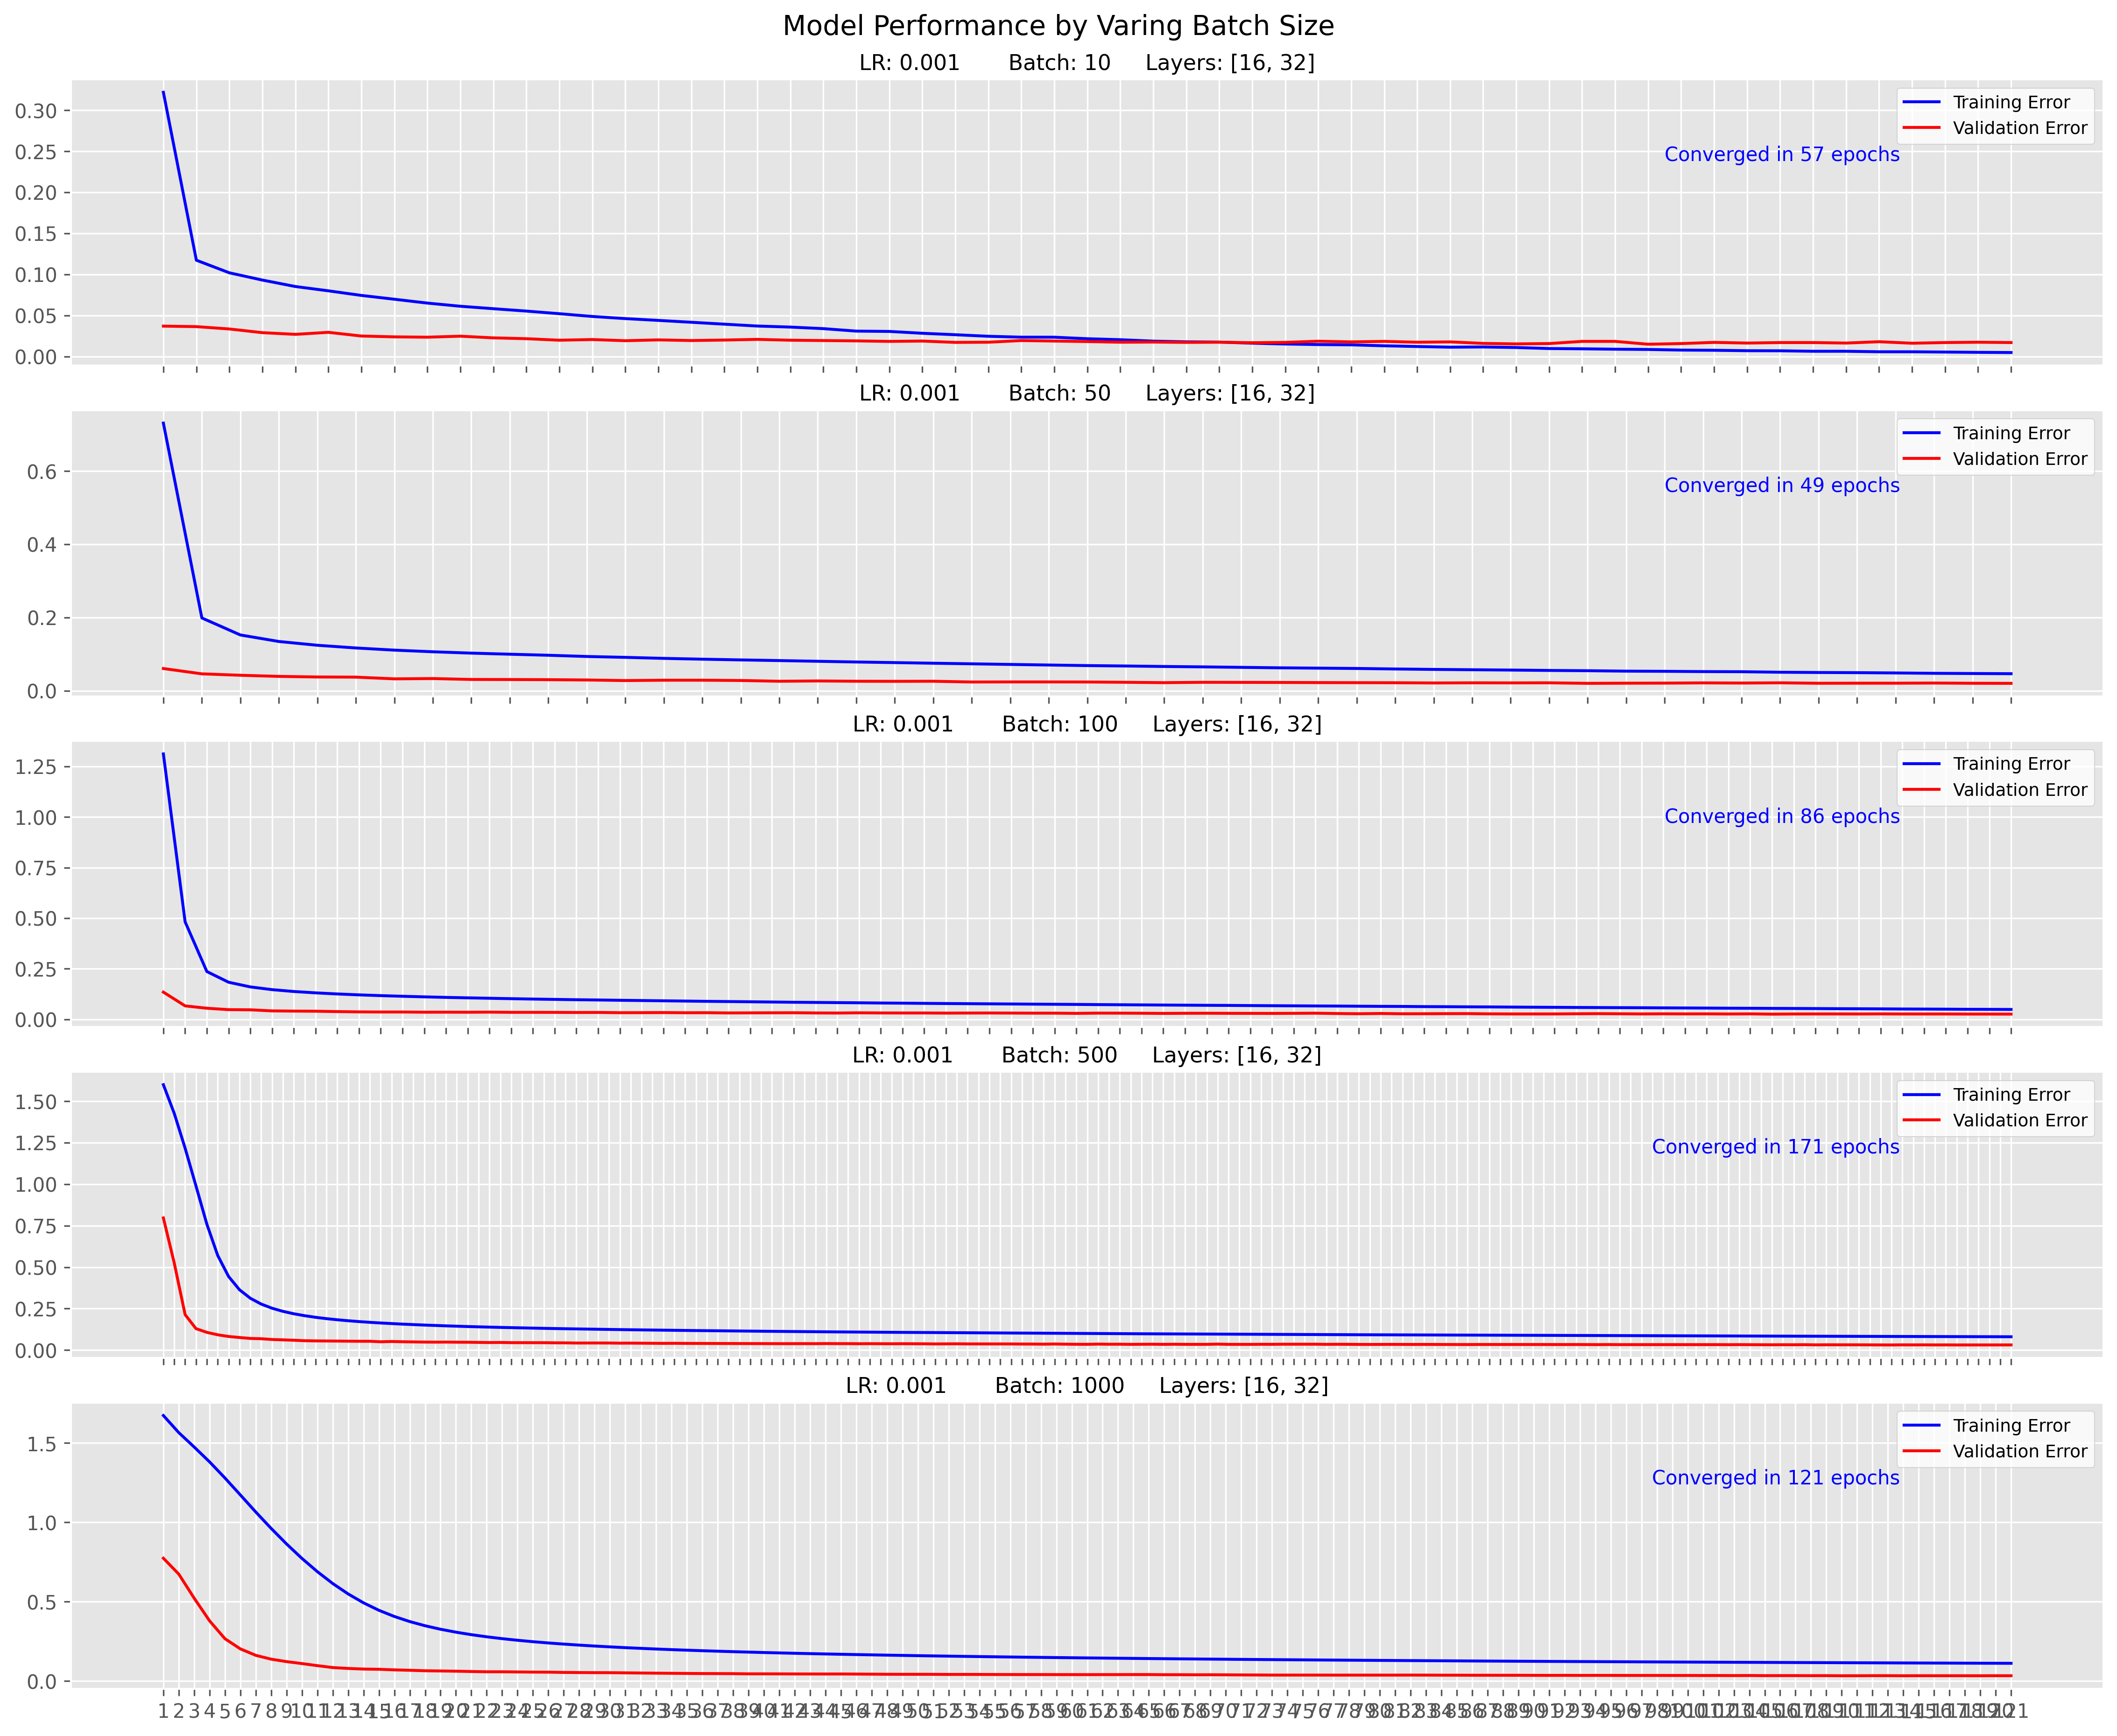

      Training error  Validation Error  Test Error
10          0.003636          0.018627    0.013038
50          0.016302          0.022222    0.017513
100         0.016629          0.022386    0.016346
500         0.025086          0.026471    0.022572
1000        0.034238          0.035131    0.030745


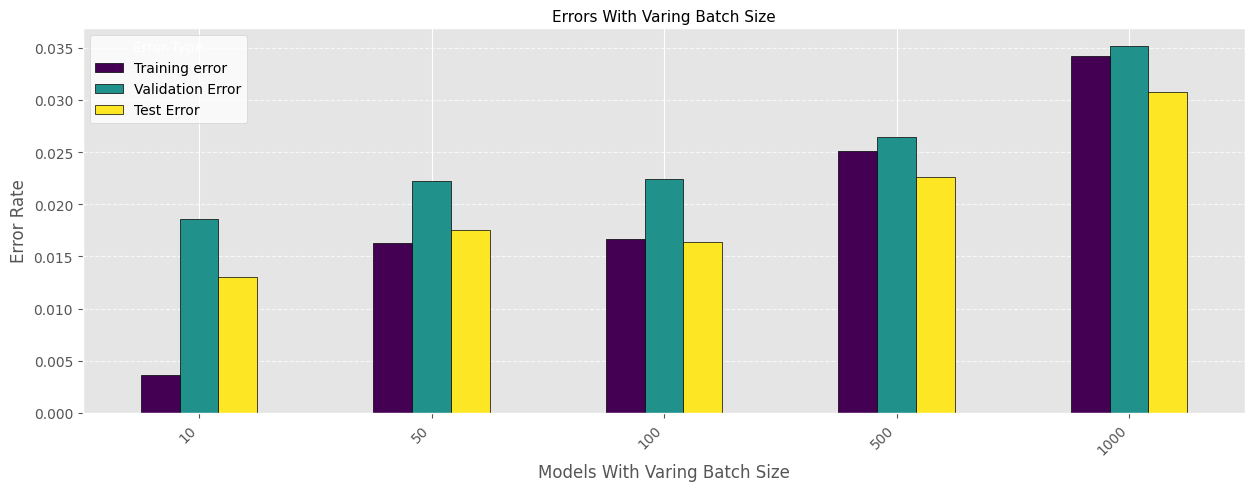

In [74]:
# Try 5 different mini-batch sizes, from 10 to 1000. What happens to the convergence properties of the NN
fig, axes = plt.subplots(
    nrows=len(lrs), ncols=1, figsize=(15, 12), dpi=300, constrained_layout=True
)
fig.suptitle(
    "Model Performance by Varing Batch Size", y=1.02, fontsize=14, color="black"
)

results = {}
for i, size in enumerate(batches):
    model = train_and_plot(ALPHA, size, NUM_HIDDN,X_train, y_train, axes[i])
    results.update(
        {size: get_errors(model, X_train, y_train, X_val, y_val, X_test, y_test)}
    )
    del model
plt.savefig("varying_batch_size.png", transparent=True)
plt.show()
plot_error_results(results, "Batch Size")

# Try 3 different values of the number of hidden units for each layer

Iteration 1, loss = 1.22519160
Validation score: 0.561070
Iteration 2, loss = 0.93333473
Validation score: 0.679943
Iteration 3, loss = 0.76788943
Validation score: 0.707925
Iteration 4, loss = 0.71446405
Validation score: 0.727124
Iteration 5, loss = 0.66592964
Validation score: 0.839052
Iteration 6, loss = 0.44028636
Validation score: 0.874387
Iteration 7, loss = 0.38446884
Validation score: 0.889297
Iteration 8, loss = 0.36203866
Validation score: 0.891136
Iteration 9, loss = 0.34748188
Validation score: 0.895221
Iteration 10, loss = 0.33745115
Validation score: 0.895221
Iteration 11, loss = 0.33044483
Validation score: 0.899306
Iteration 12, loss = 0.32491105
Validation score: 0.897263
Iteration 13, loss = 0.31978177
Validation score: 0.899918
Iteration 14, loss = 0.31385261
Validation score: 0.904003
Iteration 15, loss = 0.30841830
Validation score: 0.903186
Iteration 16, loss = 0.30173349
Validation score: 0.907884
Iteration 17, loss = 0.29569461
Validation score: 0.906454
Iterat

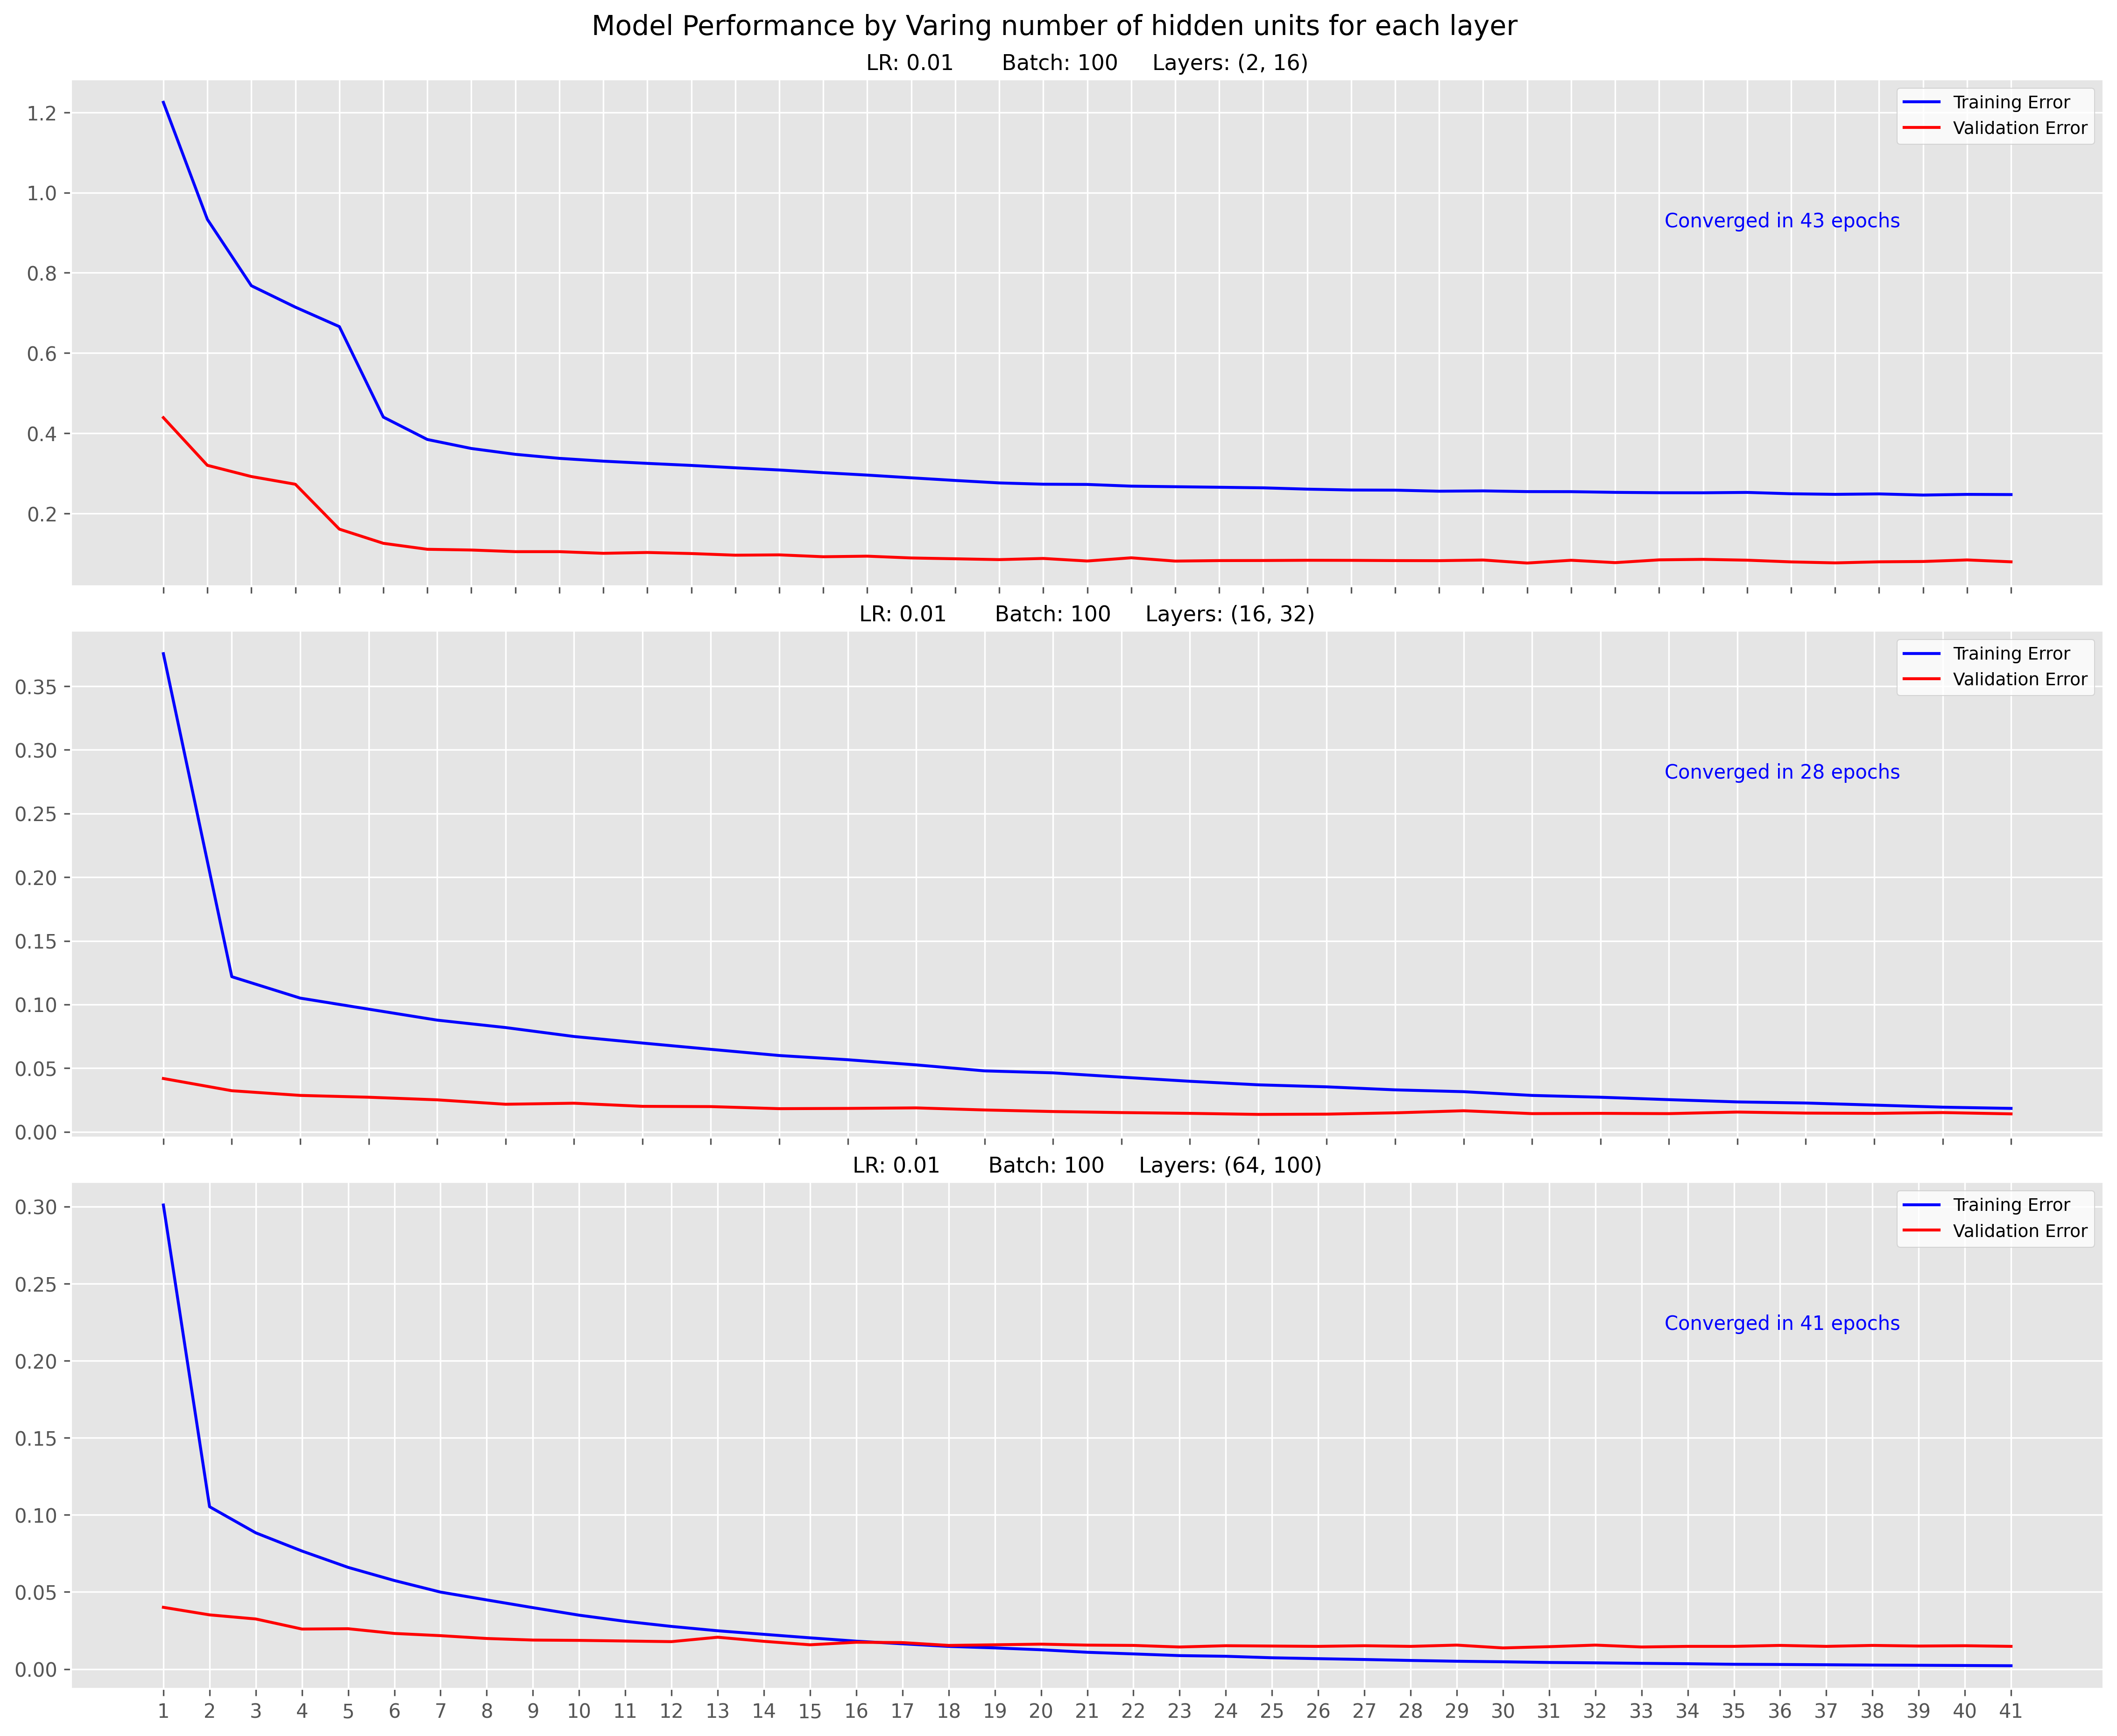

        Training error  Validation Error  Test Error
2  16         0.070273          0.079739    0.068496
16 32         0.010255          0.019118    0.014011
64 100        0.003146          0.012418    0.010702


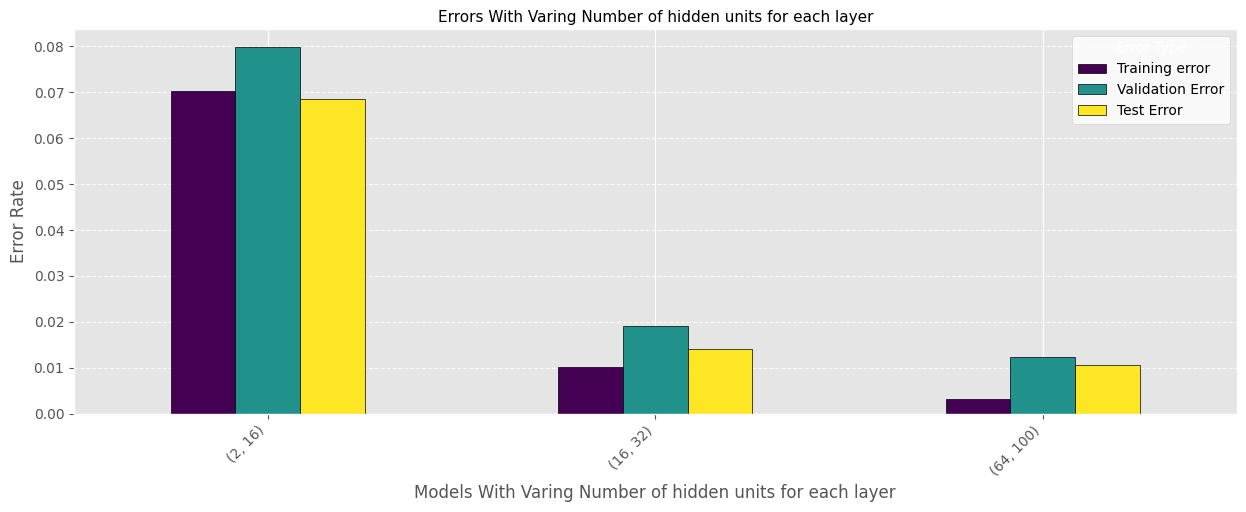

In [75]:
fig, axes = plt.subplots(
    nrows=len(hidden_layers), ncols=1, figsize=(15, 12), dpi=300, constrained_layout=True
)
fig.suptitle(
    "Model Performance by Varing number of hidden units for each layer ",
    y=1.02,
    fontsize=14,
    color="black",
)

learning_rate = 0.01
batch_size = 100
results = {}
for i, layer in enumerate(hidden_layers):
    model = train_and_plot(learning_rate, batch_size, layer, X_train, y_train, axes[i])
    results.update(
        {layer: get_errors(model, X_train, y_train, X_val, y_val, X_test, y_test)}
    )
    del model
plt.savefig("varying_number_of_neurons.png", transparent=True)
plt.show()
plot_error_results(results, "Number of hidden units for each layer")

# Best Network Hyperparameters

In [76]:
best_learning_rate = 0.01
best_batch_size = 500
best_num_hidden_layers = (64,100)

In [77]:
best_model = MLPClassifier( hidden_layer_sizes=best_num_hidden_layers,
                           learning_rate="constant",
                           learning_rate_init=best_learning_rate,
                           verbose=True,
                           validation_fraction=.1,
                           early_stopping=True,
                           batch_size=best_batch_size)

In [78]:
best_model.fit(X_train,y_train)

Iteration 1, loss = 0.22780264
Validation score: 0.973448
Iteration 2, loss = 0.06695081
Validation score: 0.982843
Iteration 3, loss = 0.04221778
Validation score: 0.985703
Iteration 4, loss = 0.03033333
Validation score: 0.985294
Iteration 5, loss = 0.02379925
Validation score: 0.981618
Iteration 6, loss = 0.02516761
Validation score: 0.984069
Iteration 7, loss = 0.01439590
Validation score: 0.988154
Iteration 8, loss = 0.00914581
Validation score: 0.990196
Iteration 9, loss = 0.01011670
Validation score: 0.986928
Iteration 10, loss = 0.01268239
Validation score: 0.988154
Iteration 11, loss = 0.00690623
Validation score: 0.988971
Iteration 12, loss = 0.00313251
Validation score: 0.989379
Iteration 13, loss = 0.00408262
Validation score: 0.990605
Iteration 14, loss = 0.00792167
Validation score: 0.982843
Iteration 15, loss = 0.02885384
Validation score: 0.988562
Iteration 16, loss = 0.00974810
Validation score: 0.988971
Iteration 17, loss = 0.00536168
Validation score: 0.988562
Iterat

MLPClassifier(batch_size=500, early_stopping=True, hidden_layer_sizes=(64, 100),
              learning_rate_init=0.01, verbose=True)

            Training error  Validation Error  Test Error
best_model        0.001389          0.011601    0.012843


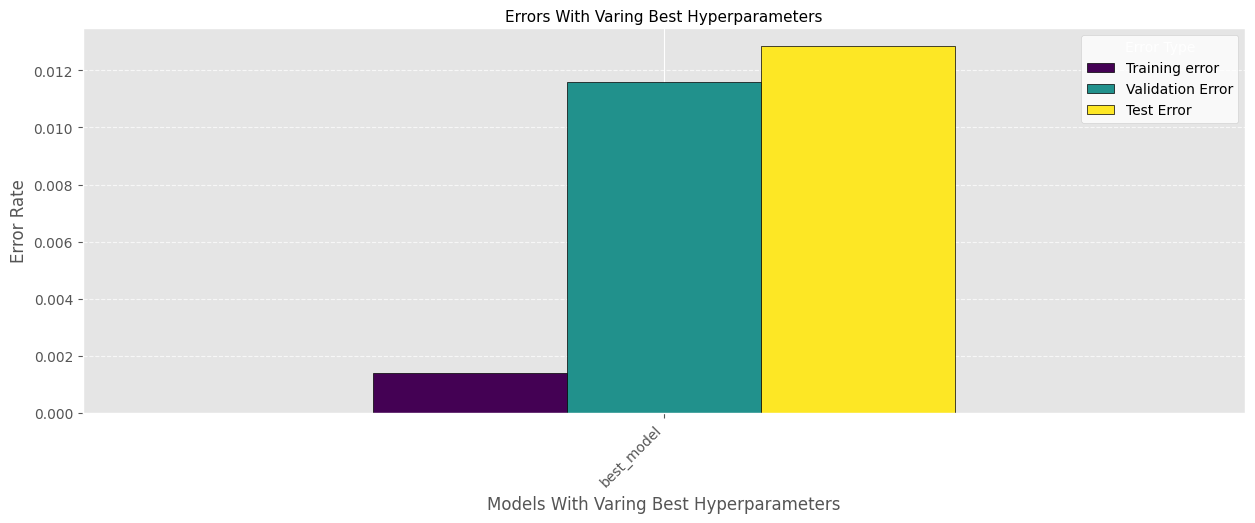

In [79]:
results = {"best_model":get_errors(best_model,X_train,y_train,X_val,y_val,X_test,y_test)}
plot_error_results(results,"Best Hyperparameters")

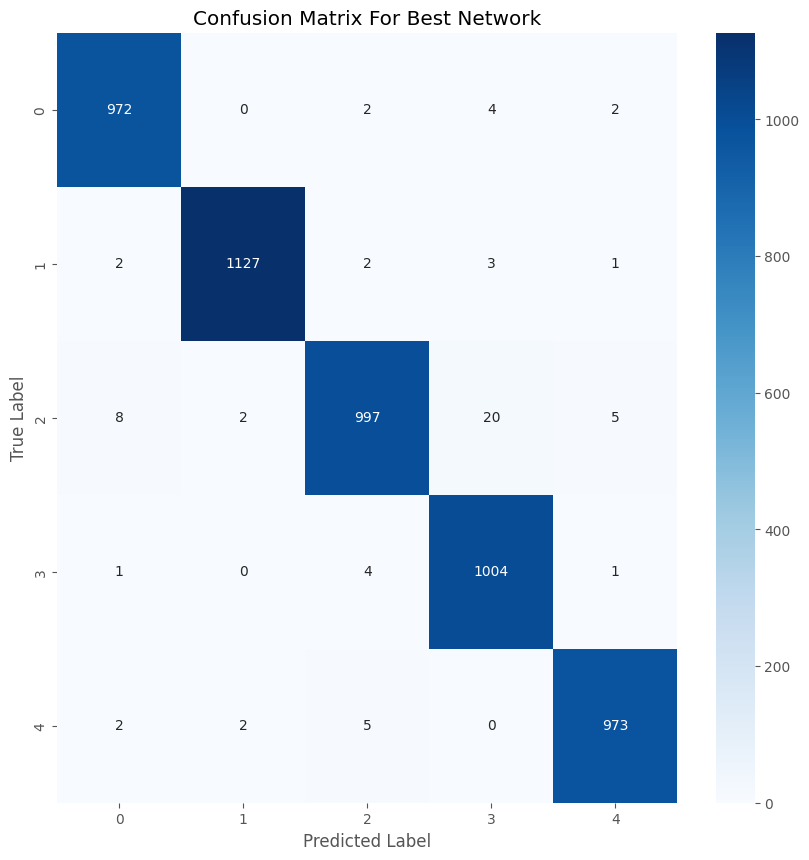

In [83]:
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10),dpi=100)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSESS,
    yticklabels=CLASSESS,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For Best Network",color="black")
plt.savefig("confusionMatrix.png", transparent=True)
plt.show()